Step 1: merging ('C', 'D') (distance=3.0) -> keep index 0, remove index 3
Step 2: merging ('B', 'A') (distance=4.0) -> keep index 1, remove index 2
Step 3: merging ('{C,D}', '{B,A}') (distance=5.0) -> keep index 0, remove index 1
Step 4: merging ('{{C,D},{B,A}}', 'E') (distance=6.0) -> keep index 0, remove index 1

Final cluster formed: {{{C,D},{B,A}},E}

History:
Step 1: merged ('C', 'D') at 3.0 -> labels now: ['{C,D}', 'A', 'B', 'E']
Step 2: merged ('B', 'A') at 4.0 -> labels now: ['{C,D}', '{B,A}', 'E']
Step 3: merged ('{C,D}', '{B,A}') at 5.0 -> labels now: ['{{C,D},{B,A}}', 'E']
Step 4: merged ('{{C,D},{B,A}}', 'E') at 6.0 -> labels now: ['{{{C,D},{B,A}},E}']

 
 



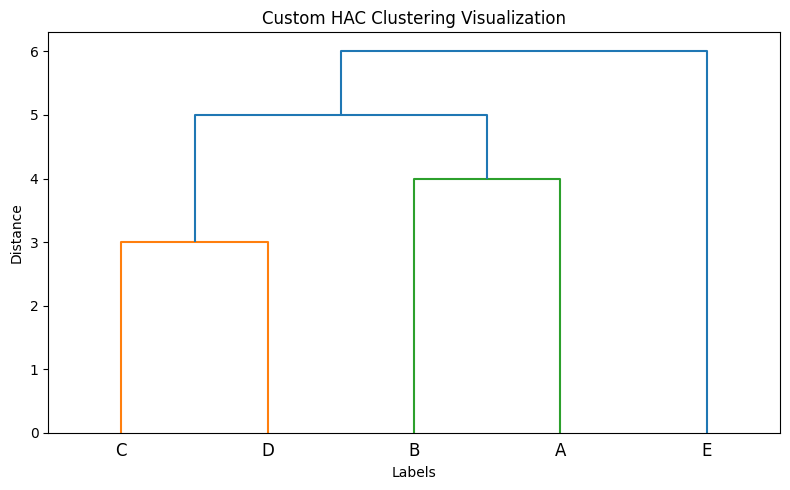

In [ ]:
import numpy as np
import time
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt


def visualize_hac_history(history):
    """
    Visualize the custom HAC merging history as a dendrogram using SciPy.
    Compatible with HAC_custom_keep_small_rep() output.
    """

    # Get all unique initial (non-merged) labels
    all_labels = set()
    for pair, _, _ in history:
        for item in pair:
            # each merge has simple or nested labels like "{C,D}"
            # we only want the atomic ones
            if "," not in item and "{" not in item and "}" not in item:
                all_labels.add(item)
    all_labels = sorted(list(all_labels))
    n = len(all_labels)

    # Assign numeric IDs to each original label
    label_to_id = {lbl: i for i, lbl in enumerate(all_labels)}
    next_cluster_id = n
    linkage_rows = []

    # Track which cluster name maps to which numeric ID
    cluster_id_map = {}

    for pair, dist, _ in history:
        a, b = pair

        # Get numeric IDs (for old or new clusters)
        id_a = cluster_id_map.get(a, label_to_id.get(a))
        id_b = cluster_id_map.get(b, label_to_id.get(b))

        if id_a is None or id_b is None:
            raise ValueError(f"Unrecognized cluster in pair {pair}")

        # Create new cluster ID
        new_cluster_id = next_cluster_id
        next_cluster_id += 1

        # Each merge adds one row [idx1, idx2, distance, sample_count]
        linkage_rows.append([id_a, id_b, dist, 2])

        # Register new cluster name for later merges
        merged_name = f"{{{a},{b}}}"
        cluster_id_map[merged_name] = new_cluster_id

    linkage_matrix = np.array(linkage_rows, dtype=float)

    # Plot dendrogram
    plt.figure(figsize=(8, 5))
    dendrogram(linkage_matrix, labels=all_labels, orientation="top")
    plt.title("Custom HAC Clustering Visualization")
    plt.xlabel("Labels")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()


def is_square(matrix):
    return matrix.shape[0] == matrix.shape[1]

def sort_matrix(matrix, labels):
    """Sort matrix rows and columns by their average distance (smallest → largest)."""
    averages = np.mean(matrix, axis=1)
    order = np.argsort(averages)
    matrix = matrix[order][:, order]
    labels = [labels[i] for i in order]
    return matrix, labels

def find_smallest_pair(matrix):
    """Find smallest non-diagonal distance and return indices and value."""
    min_val = np.inf
    min_pair = (None, None)
    n = matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i != j and matrix[i, j] < min_val:
                min_val = matrix[i, j]
                min_pair = (i, j)
    return min_pair, min_val

def remove_index(matrix, labels, idx):
    """Remove row and column at index idx, and remove corresponding label."""
    # Remove row and column idx from matrix, remove label[idx]
    mask = np.ones(len(labels), dtype=bool)
    mask[idx] = False
    new_matrix = matrix[mask][:, mask]
    new_labels = [labels[k] for k in range(len(labels)) if k != idx]
    return new_matrix, new_labels

def HAC_custom_keep_small_rep(matrix, labels):
    """
    Custom HAC: each step:
      - sort matrix/labels
      - find smallest pair (i,j)
      - create merged name and store it by replacing the smaller index (min(i,j))
      - remove the larger index (max(i,j)) row+col from matrix & labels
      - repeat until 1 label remains
    Distances are NOT recomputed (no average linkage).
    """
    if not is_square(matrix):
        raise ValueError("Matrix must be square.")

    history = []
    step = 1

    # Work on copies so we don't mutate the caller's arrays
    M = matrix.copy()
    L = labels.copy()

    while len(L) > 1:
        # sort for this round
        M, L = sort_matrix(M, L)

        (i, j), val = find_smallest_pair(M)
        a, b = min(i, j), max(i, j)   # a is the smaller index, b the larger index

        pair = (L[a], L[b])
        merged_name = f"{{{L[a]},{L[b]}}}"

        print(f"Step {step}: merging {pair} (distance={val}) -> keep index {a}, remove index {b}")
        step += 1

        # Replace the smaller index label with the merged cluster name
        L[a] = merged_name

        # Remove the larger index (row & column b) from matrix and labels
        M, L = remove_index(M, L, b)

        # Save history (pair, distance, snapshot of labels)
        history.append((pair, val, L.copy()))


        time.sleep(1)

        if len(L) == 1:
            print(f"\nFinal cluster formed: {L[0]}")
            break

    return history

# Example usage
if __name__ == "__main__":
    labels = ["A", "B", "C", "D", "E"]
    matrix = np.array([
        [0, 4, 7, 10, 9],
        [4, 0, 5, 11, 10],
        [7, 5, 0, 3, 6],
        [10, 11, 3, 0, 8],
        [9, 10, 6, 8, 0]
    ], dtype=float)
    history = HAC_custom_keep_small_rep(matrix, labels)

    print("\nHistory:")
    for step, (pair, val, labs) in enumerate(history, 1):
        print(f"Step {step}: merged {pair} at {val} -> labels now: {labs}")
    print('\n \n \n')
    history=visualize_hac_history(history)